# 门控循环单元(GRU)

关注一个序列
- 不是每个观察值都同等重要
- 想只记住相关的观察需要：
  - 能关注的机制(更新门)
  - 能遗忘的机制(重置门)

重置门和更新门

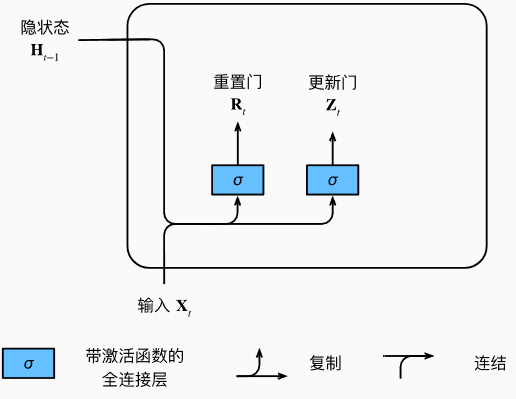

候选隐状态

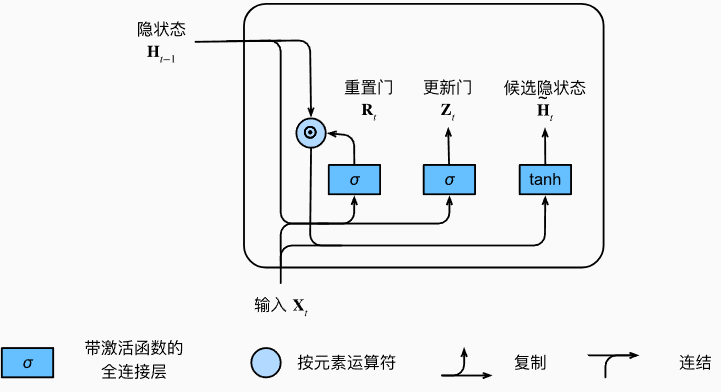

隐状态

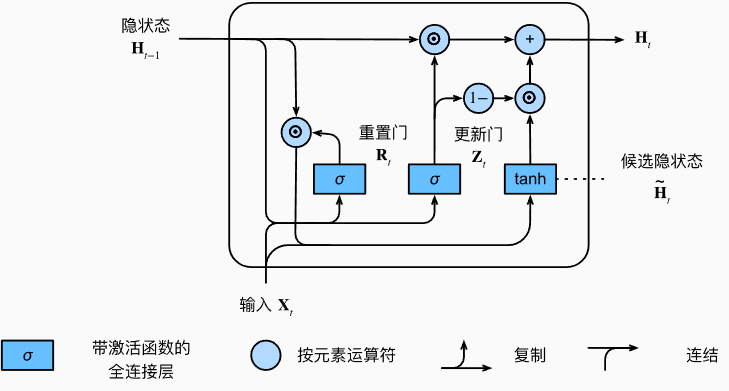

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [20]:
#初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    """定义模型参数"""
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size= shape, device= device)* 0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device= device))
    #更新门、重置门、候选隐藏状态参数
    W_xz, W_hz, b_z = three()
    W_xr, W_hr, b_r = three()
    W_xh, W_hh, b_h = three()

    #输出层参数
    W_hq = normal((num_hiddens, num_outputs)) 
    b_q = torch.zeros(num_outputs, device= device)
    #对模型参数附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params 

In [21]:
#初始化模型状态
def init_gru_state(batch_size, num_hiddens, device):
    """初始化模型参数为0"""
    return (torch.zeros((batch_size, num_hiddens), device= device), )

In [22]:
#定义GRU模型
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim= 0), (H, )

困惑度 1.1, 41044.0 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
traveller fir can he man andeneised bowy froven if the flen


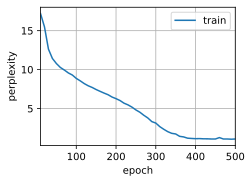

In [23]:
#模型训练与预测
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

困惑度 1.0, 344176.4 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


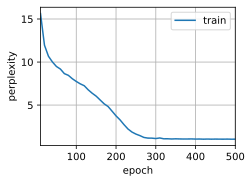

In [24]:
#使用Pytorch的API简洁实现
num_inputs = vocab_size
#(输出数，隐藏状态数)
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
#将模型移动至GPU上训练
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)